In [3]:
import pylab
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.spatial import distance
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import basinhopping, differential_evolution
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import string

In [4]:
## Model structure
Mt = 40
Nt = 20

Ma = 20
Na = 3

## Model parameters

# Unisensory receptive fields
phit_0 = 1
sigmat_phi = 0.5
phia_0 = 1
sigmaa_phi = 10

# External stimuli
it_0 = 2.5
sigmat_i = 0.3
sigmat_v = 0.1
xt_0 = 10 
yt_0 = 5

ia_0 = 3.6
sigmaa_i = 0.3
sigmaa_v = 0.4
ya_0 = 5
xa_0 = 100

tt_0 = 0
ta_0 = 0

In [5]:
## Receptive fields

# Tactile RF centres
xt = np.arange(1,Mt+1)*0.5 
yt = np.arange(1,Nt+1)*0.5

# Auditory RF centres
xa = (np.arange(1,Ma+1)*10)-5
ya = (np.arange(1,Na+1)*10)-15
              
def phit(x,y):
    phi = np.zeros((Mt,Nt))
    for i in range(Mt):
        for j in range(Nt):
            phi[i][j] = phit_0*np.exp(-((np.square(xt[i]-x)+np.square(yt[j]-y))/(2*np.square(sigmat_phi))))
    return phi

def phia(x,y):
    phi = np.zeros((Ma,Na))
    for i in range(Ma):
        for j in range(Na):
            phi[i][j] = phia_0*np.exp(-((np.square(xa[i]-x)+np.square(ya[j]-y))/(2*np.square(sigmaa_phi))))
    return phi

# Calculation
dif = 0.2
xt_i = np.arange(0,20+dif,dif)
yt_n = np.arange(0,10+dif,dif)

phi_t = np.zeros((Mt,Nt,len(xt_i),len(yt_n)))        
for k in range(len(xt_i)):
    for l in range(len(yt_n)):
        phi_t[:,:,k,l] = phit(xt_i[k],yt_n[l])
        
xa_i = np.arange(0,200+dif,dif)
ya_n = np.arange(0,30+dif,dif)

phi_a = np.zeros((Ma,Na,len(xa_i),len(ya_n)))        
for k in range(len(xa_i)):
    for l in range(len(ya_n)):
        phi_a[:,:,k,l] = phia(xa_i[k],ya_n[l])
        

## External stimulus
def stimt(x,y,t):
    if t<tt_0: 
        I = 0
    else: 
        #v = np.random.normal(0, sigmat_v)
        #I = (it_0+sigmat_v*v)*np.exp(- (np.square(xt_0-x)+np.square(yt_0-y))/(2*np.square(sigmat_i)))
        I = (it_0)*np.exp(- (np.square(xt_0-x)+np.square(yt_0-y))/(2*np.square(sigmat_i)))
    return I 

def stima(x,y,t,xa_0):
    if t<ta_0: 
        I = 0
    else: 
        #v = np.random.normal(0, sigmaa_v)
        #I = (ia_0+sigmaa_v*v)*np.exp(- (np.square(xa_0-x)+np.square(ya_0-y))/(2*np.square(sigmaa_i)))
        I = (ia_0)*np.exp(- (np.square(xa_0-x)+np.square(ya_0-y))/(2*np.square(sigmaa_i)))
    return I 

## Unisensory input
def PHIt(t):

        PHI = np.zeros((Mt,Nt,len(xt_i),len(yt_n)))        
        
        for k in range(len(xt_i)):
            for l in range(len(yt_n)):
                PHI[:,:,k,l] = np.multiply(phi_t[:,:,k,l],stimt(xt_i[k],yt_n[l],t))
        PHI = np.sum(PHI,axis=3)
        PHI = np.sum(PHI,axis=2)
        
        return PHI
    
def PHIa(t,xa_0):

        PHI = np.zeros((Ma,Na,len(xa_i),len(ya_n)))        
        
        for k in range(len(xa_i)):
            for l in range(len(ya_n)):
                PHI[:,:,k,l] = np.multiply(phi_a[:,:,k,l],stima(xa_i[k],ya_n[l],t,xa_0))
        PHI = np.sum(PHI,axis=3)
        PHI = np.sum(PHI,axis=2)
        
        return PHI

In [6]:
## Lateral connections in unisensory areas

def Lw(Lt_ex,Lt_in,sigmat_ex,sigmat_in,La_ex,La_in,sigmaa_ex,sigmaa_in):
    # Tactile Connections
    Lt = np.zeros((Mt*Nt,Mt*Nt))

    for i in range(Mt*Nt):
        for j in range(Mt*Nt):
            if i==j: 
                Lt[i,j] = 0
            else:
                Dtx = xt[np.floor_divide(i,Nt)] - xt[np.floor_divide(j,Nt)]
                Dty = yt[np.remainder(i,Nt)] - yt[np.remainder(j,Nt)]
                Lt[i,j] = Lt_ex*np.exp(- (np.square(Dtx)+np.square(Dty))/(2*np.square(sigmat_ex)))-Lt_in*np.exp(- (np.square(Dtx)+np.square(Dty))/(2*np.square(sigmat_in)))

    # Auditory Connections
    La = np.zeros((Ma*Na,Ma*Na))

    for i in range(Ma*Na):
        for j in range(Ma*Na):
            if i==j: 
                La[i,j] = 0
            else:
                Dax = xa[np.floor_divide(i,Na)] - xa[np.floor_divide(j,Na)]
                Day = ya[np.remainder(i,Na)] - ya[np.remainder(j,Na)] #before was remainder-1
                La[i,j] = La_ex*np.exp(- (np.square(Dax)+np.square(Day))/(2*np.square(sigmaa_ex)))-La_in*np.exp(- (np.square(Dax)+np.square(Day))/(2*np.square(sigmaa_in)))
    return Lt,La            
                
# Lateral inputs
def LIt(z):
    # z is a matrix of MtxNt dimensions
    LI = np.zeros(Mt*Nt)
    z = np.reshape(z,(1,Mt*Nt))
    for i in range(Mt*Nt):
            LI[i] = np.sum(np.multiply(Lt[i,:],z[0,:])) 
    LI = np.reshape(LI,(Mt,Nt))
    return LI

def LIa(z):
    # z is a matrix of MtxNt dimensions
    LI = np.zeros(Ma*Na)
    z = np.reshape(z,(1,Ma*Na))
    for i in range(Ma*Na):
            LI[i] = np.sum(np.multiply(La[i,:],z[0,:])) 
    LI = np.reshape(LI,(Ma,Na))
    return LI

In [7]:
## Feedforward and feedback synapses

def Fw (Wt_0,Wa_0,Bt_0,Ba_0):
    k1 = 15.41902756 #10 #cm
    k2 = 813.75069556 #cm
    alpha = 0.9 #0.9

    # Tactile connections
    Bt = np.ones((Mt,Nt))*Bt_0
    Wt = np.ones((Mt,Nt))*Wt_0

    # Auditory connections
    Ba = np.zeros((Ma,Na))
    Wa = np.zeros((Ma,Na))

    lim = 66.0879161 # originally 60

    for i in range(Ma):
        for j in range(Na):
            if (xa[i]<lim) & (ya[j]<20):
                D = 0
            else: 
                D = distance.euclidean((xa[i],ya[j]),(lim,ya[j]))              
            Ba[i,j] = alpha*Ba_0*np.exp(- D/k1)+(1-alpha)*Ba_0*np.exp(- D/k2)
            Wa[i,j] = alpha*Wa_0*np.exp(- D/k1)+(1-alpha)*Wa_0*np.exp(- D/k2)
    return Wt,Wa,Bt,Ba

# Feedback inputs
def bt(z):
    #bt = np.zeros(Mt,Nt)
    bt = np.multiply(Bt,z)
    return bt

def ba(z,Ba):
    #bt = np.zeros(Mt,Nt)
    ba = np.multiply(Ba,z)
    return ba


In [8]:
## Neuron activity in unisensory areas
ft_min = -0.12
ft_max = 1
qt_c = 19.43
rt = 0.34

fa_min = -0.12
fa_max = 1
qa_c = 19.43
ra = 0.34

tau = 20

def psit(qt,b):
    y = qt
    for i in range(Mt):
        for j in range(Nt):
            y[i,j] = (ft_min+ft_max*np.exp((qt[i,j]-qt_c)*rt+b))/(1+np.exp((qt[i,j]-qt_c)*rt+b))
    return y

def psia(qa,b):
    y = qa
    for i in range(Ma):
        for j in range(Na):
            y[i,j] = (fa_min+fa_max*np.exp((qa[i,j]-qa_c)*ra+b))/(1+np.exp((qa[i,j]-qa_c)*ra+b))
    return y

## Multisensory neuron activity
fm_min = 0
fm_max = 1
qm_c = 12
rm = 0.6

def psim(qm):
    y = (fm_min+fm_max*np.exp((qm-qm_c)*rm))/(1+np.exp((qm-qm_c)*rm))
    return y

## Evolutionary prunning mechanism
def prun(WM,pr):
    newM = np.copy(WM)
    newM[newM < pr] = 0
    return newM

In [9]:
## Experiment function - Canzonieri 2012 experiment

def experimentrun(a_distances,time,b,pr):
    dt = 0.4
    timesteps = int(time/dt)
    ndist = len(a_distances)
    
    RTs = np.zeros(ndist)
    ti = PHIt(0) 
    PrBa = prun(Ba,pr)
    PrWa = prun(Wa,pr*2.6)
    dtau = dt/tau
    
    qt = np.zeros((Mt,Nt,timesteps+1,ndist))
    ut = np.zeros((Mt,Nt,timesteps+1,ndist))
    zt = np.zeros((Mt,Nt,timesteps+1,ndist))
    pt = np.zeros((Mt,Nt,timesteps+1,ndist))

    qa = np.zeros((Ma,Na,timesteps+1,ndist))
    ua = np.zeros((Ma,Na,timesteps+1,ndist))
    za = np.zeros((Ma,Na,timesteps+1,ndist))
    pa = np.zeros((Ma,Na,timesteps+1,ndist))

    qm = np.zeros((timesteps+1,ndist))
    um = np.zeros((timesteps+1,ndist))
    zm = np.zeros((timesteps+1,ndist))
    pm = np.zeros((timesteps+1,ndist))
    
    ZT = np.zeros((1,timesteps+1,ndist))
    
    for d in range(ndist):
        xa_0 = a_distances[d]     
        ai = PHIa(0,xa_0)

        for i in range(timesteps):    
            # Tactile activity
            ut[:,:,i+1,d] = ti+LIt(zt[:,:,i,d])+bt(zm[i,d])
            qt[:,:,i+1,d] = qt[:,:,i,d] + dtau*(-qt[:,:,i,d]+ut[:,:,i,d])
            pt[:,:,i+1,d] = psit(qt[:,:,i,d],b)
            zt[:,:,i+1,d] = pt[:,:,i,d]*np.heaviside(pt[:,:,i,d],0)

            ZT[0,i+1,d] = np.sum(zt[:,:,i,d])

            # Auditory activity
            ua[:,:,i+1,d] = ai+LIa(za[:,:,i,d])+ba(zm[i,d],PrBa) 
            qa[:,:,i+1,d] = qa[:,:,i,d] + dtau*(-qa[:,:,i,d]+ua[:,:,i,d])
            pa[:,:,i+1,d] = psia(qa[:,:,i,d],b)
            za[:,:,i+1,d] = pa[:,:,i,d]*np.heaviside(pa[:,:,i,d],0)

            # Multisensory activity
            um[i+1,d] = np.sum(np.multiply(Wt,zt[:,:,i,d])) + np.sum(np.multiply(PrWa,za[:,:,i,d]))
            qm[i+1,d] = qm[i,d] + dtau*(-qm[i,d]+um[i,d])
            pm[i+1,d] = psim(qm[i,d])
            zm[i+1,d] = pm[i,d]*np.heaviside(pm[i,d],0)    

        RT = dt*(np.abs(ZT[:,:,d] - ZT[0,timesteps,d]*0.9)).argmin()
        RTs[d] = RT
    return RTs

## Sigmoid function to fit
def RTsig(d,etamin,etamax,dc,h):
    return (etamin+etamax*np.exp((d-dc)/h))/(1+np.exp((d-dc)/h))

## Sigmoid function fitting
def sigfit(RTs,a_distances):
    t1 = np.linspace(38, 112, 100) # These boundaries may change if the velocity is different from 30 cm/s
    popt, pcov = curve_fit(RTsig, a_distances, RTs,bounds=([0,0,38,0],[100,200,112,100])) # Same as above. Beware of boundaries.
    sigpar = np.asarray(popt)

    etamin = sigpar[0] 
    etamax = sigpar[1]
    dc = sigpar[2]
    h = sigpar[3]
    return etamin,etamax,dc,h

In [ ]:
HCdata = pd.read_excel (r'C:\\Users\\renat\Dissertation\PPS_data_SCZ_SPQ.xlsx',sheet_name='HC') #for an earlier version of Excel, you may need to use the file extension of 'xls'
SCZdata = pd.read_excel (r'C:\\Users\\renat\Dissertation\PPS_data_SCZ_SPQ.xlsx',sheet_name='SCZ') #for an earlier version of Excel, you may need to use the file extension of 'xls'
SPQdata = pd.read_excel (r'C:\\Users\\renat\Dissertation\PPS_data_SCZ_SPQ.xlsx',sheet_name='high spq') #for an earlier version of Excel, you may need to use the file extension of 'xls'
LSPQdata = pd.read_excel (r'C:\\Users\\renat\Dissertation\PPS_data_SCZ_SPQ.xlsx',sheet_name='low spq') #for an earlier version of Excel, you may need to use the file extension of 'xls'

sets = [HCdata,SCZdata,SPQdata,LSPQdata]
RTdata = []

for i in sets:
    subjects = i['Subject'].unique()
    delays = i[(i['Sound']=='Loom')&(i['Cond'] != 'Loom_NO')]['Cond'].unique()
    delays = np.delete(delays,np.where(delays=='Loom_-700')[0])
    idx = [3,4,0,1,2]
    delays = delays[idx]
    RTs = []
    
    for s in subjects:
        meanRTs = []
        for t in delays:
            RT = i[(i['Subject'] == s)&(i['Cond'] == t)]['Rtpul']           
            meanRTs.append(np.mean(RT))
        RTs.append(meanRTs)
    RTdata.append(RTs)
    
HC_RT = np.asarray(RTdata[0])
SCZ_RT = np.asarray(RTdata[1])
SPQ_RT = np.asarray(RTdata[2])
LSPQ_RT = np.asarray(RTdata[3])


In [11]:
## Experiments setup. 

# Calculate distance in cms. Speaker is positioned at 100cm from the hand. 
times = np.asarray([300,800,1500,2200,2700])
timesweep = np.arange(300,2800,100)
ts = timesweep/1000
v = 30 #22 cm/s / 28 gives good fit as well

# Initial setup
trials = 1 #18 in behavioural study
a_distances = (120 - ts*v) # distance points in cm (network coordinates)
simtime = 200 #ms # 0.1 in behavioural study? 
# Synapses
Lt,La = Lw(0.15,0.05,1,4,0.15,0.05,20,80)
Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) 

In [30]:
## Experiment run
bi = 0.62904397
prlevel = 0.23709415

#x: array([2.86743028, 0.08121124])
HC_RTs = experimentrun(a_distances,simtime,bi,prlevel)

Central Point:68.77323000788537cm 1040.8923330704877ms
Slope:0.10992957675463
5.168811752524355 -73.54460144222476


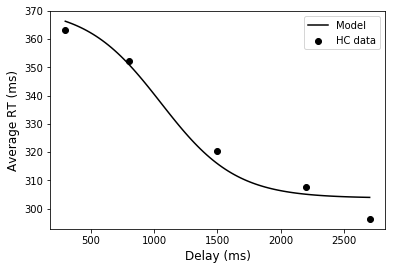

In [32]:
# HC RT fitting

idx = [0,5,12,19,24]
xf = np.take(HC_RTs,idx)
yf = np.mean(HC_RT,axis=0)
etamin,etamax,dc,h = sigfit(HC_RTs,a_distances)

m = (xf.size * np.sum(xf*yf) - np.sum(xf) * np.sum(yf)) / (xf.size*np.sum(xf*xf) - np.sum(xf) ** 2)
bias = (np.sum(yf) - m*np.sum(xf)) / xf.size

#plt.figure(1)
#plt.scatter(RTs[0],np.mean(HC_RT,axis=0)) 

plt.figure(2)
times1 = np.linspace(300, 2700, 100)
t1 = np.linspace(38, 112, 100)
plt.scatter(times,np.mean(HC_RT,axis=0),color='black',label='HC data') #15
plt.plot(np.flip(times1),m*RTsig(t1,etamin,etamax,dc,h)+bias,color='black',label='Model')
plt.xlabel('Delay (ms)',size=12)
plt.ylabel('Average RT (ms)',size=12)
plt.legend()

print("Central Point:"+str(np.mean(dc)-20)+"cm",str(((120-np.mean(dc))/v)*1000)+"ms")
print("Slope:"+str(1/np.mean(h)))
print(m,bias)

In [13]:
## Experiment run
bi = 4.49317781
prlevel = 1.94636878
SCZ_RTs = experimentrun(a_distances,simtime,bi,prlevel)


Central Point:53.31360196699582cm 1556.2132677668062ms
Slope:0.173873012604015
14.134517692865165 -252.57930683691546


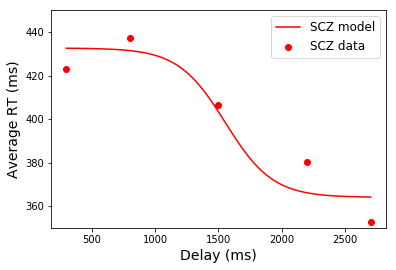

In [23]:
# SCZ RT fitting

idx = [0,5,12,19,24]
xf = np.take(SCZ_RTs,idx)
yf = np.mean(SCZ_RT,axis=0)
sczetamin,sczetamax,sczdc,sczh = sigfit(SCZ_RTs,a_distances)

sczm = (xf.size * np.sum(xf*yf) - np.sum(xf) * np.sum(yf)) / (xf.size*np.sum(xf*xf) - np.sum(xf) ** 2)
sczbias = (np.sum(yf) - sczm*np.sum(xf)) / xf.size

plt.figure(2)
times1 = np.linspace(300, 2700, 100)
t1 = np.linspace(38, 112, 100)
plt.scatter(times,np.mean(SCZ_RT,axis=0),color='red',label='SCZ data') #15
plt.plot(np.flip(times1),sczm*RTsig(t1,sczetamin,sczetamax,sczdc,sczh)+sczbias,color='red',label='SCZ model')
plt.xlabel('Delay (ms)',size=14)
plt.ylabel('Average RT (ms)',size=14)
plt.ylim(350,450)
plt.legend(fontsize = 'large')
plt.savefig('Results/scznetworkmodel.png', bbox_inches='tight')

print("Central Point:"+str(np.mean(sczdc)-20)+"cm",str(((120-np.mean(sczdc))/v)*1000)+"ms")
print("Slope:"+str(1/np.mean(sczh)))

print(sczm,sczbias)

In [24]:
# SPQ RT fitting

## Experiment run  
bi = 4.30153794
prlevel = 0.14795582

SPQ_RTs = experimentrun(a_distances,simtime,bi,prlevel)

Central Point:62.12685623653218cm 1262.4381254489274ms
Slope:0.09756136865965953
14.732288609548426 -455.318746424054


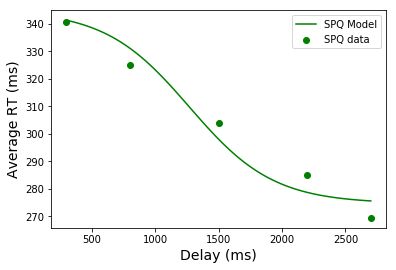

In [28]:
## SPQ fitting
idx = [0,5,12,19,24]
xf = np.take(SPQ_RTs,idx)
yf = np.mean(SPQ_RT,axis=0)
spqetamin,spqetamax,spqdc,spqh = sigfit(SPQ_RTs,a_distances)

spqm = (xf.size * np.sum(xf*yf) - np.sum(xf) * np.sum(yf)) / (xf.size*np.sum(xf*xf) - np.sum(xf) ** 2)
spqbias = (np.sum(yf) - spqm*np.sum(xf)) / xf.size

plt.figure(2)
times1 = np.linspace(300, 2700, 100)
t1 = np.linspace(38, 112, 100)
plt.scatter(times,np.mean(SPQ_RT,axis=0),color='green',label='SPQ data')
plt.plot(np.flip(times1),spqm*RTsig(t1,spqetamin,spqetamax,spqdc,spqh)+spqbias,color='green',label='SPQ Model')
plt.xlabel('Delay (ms)',size=14)
plt.ylabel('Average RT (ms)',size=14)
plt.legend()

print("Central Point:"+str(np.mean(dc)-20)+"cm",str(((120-np.mean(dc))/v)*1000)+"ms")
print("Slope:"+str(1/np.mean(h)))
print(spqm,spqbias)


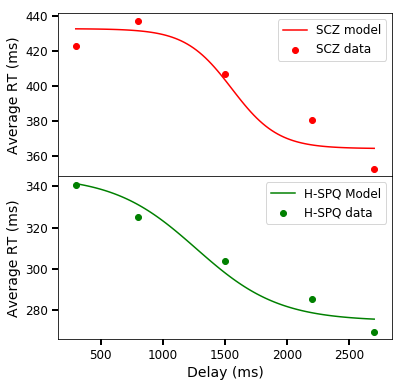

In [49]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,6))

times1 = np.linspace(300, 2700, 100)
t1 = np.linspace(38, 112, 100)

ax1.scatter(times,np.mean(SCZ_RT,axis=0),color='red',label='SCZ data') #15
ax1.plot(np.flip(times1),sczm*RTsig(t1,sczetamin,sczetamax,sczdc,sczh)+sczbias,color='red',label='SCZ model')
ax1.set_ylabel('Average RT (ms)',size=14)
ax1.tick_params(length=6, width=2,labelsize = 'large')
ax1.legend(fontsize = 'large')

ax2.scatter(times,np.mean(SPQ_RT,axis=0),color='green',label='H-SPQ data') 
ax2.plot(np.flip(times1),spqm*RTsig(t1,spqetamin,spqetamax,spqdc,spqh)+spqbias,color='green',label='H-SPQ Model')
ax2.set_xlabel('Delay (ms)',size=14)
ax2.set_ylabel('Average RT (ms)',size=14)
ax2.tick_params(length=6, width=2,labelsize = 'large')
ax2.legend(fontsize = 'large')

plt.subplots_adjust(hspace=.0)
plt.savefig('Results/groupfitting.png', bbox_inches='tight')


4.788482561128575


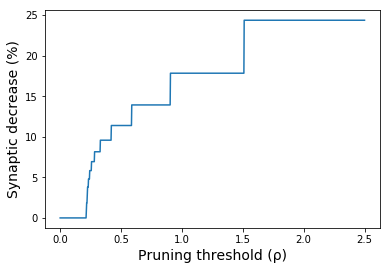

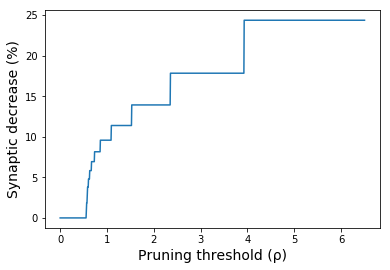

In [11]:
decrease = []
for i in np.linspace(0,2.5,1000):
    newM = prun(Ba,i)
    decrease.append(100-np.sum(newM)/np.sum(Ba)*100)

plt.figure(1)
plt.plot(np.linspace(0,2.5,1000),decrease);
plt.xlabel('Pruning threshold (\u03C1)',size=14)
plt.ylabel('Synaptic decrease (%)',size=14)
plt.savefig('completepruninglevels.png', bbox_inches='tight')


decrease = []
for i in np.linspace(0,2.5,1000):
    newM = prun(Wa,i*2.6)
    decrease.append(100-np.sum(newM)/np.sum(Wa)*100)

plt.figure(2)
plt.plot(np.linspace(0,2.5*2.6,1000),decrease);
plt.xlabel('Pruning threshold (\u03C1)',size=14)
plt.ylabel('Synaptic decrease (%)',size=14)
plt.savefig('completepruninglevels2.png', bbox_inches='tight')

newtry = prun(Ba,0.23709415)
print(100-np.sum(newtry)/np.sum(Ba)*100)

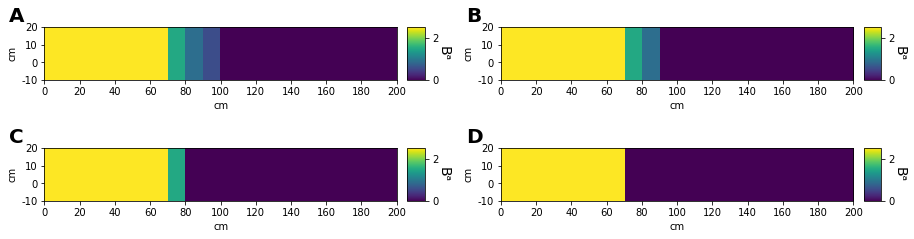

In [46]:
## Plot feedback weights at different pruning levels

prlvls = np.asarray([0.5,0.75,1.25,2])

fig, axs = plt.subplots(2, 2, figsize=(15, 5));

plotlist = [221,222,223,224]

for i in range(len(prlvls)):
    newM = prun(Ba,prlvls[i])

    ax = plt.subplot(plotlist[i])
    im = ax.imshow(newM.transpose())
    ax.set_ylabel('cm')
    ax.set_xlabel('cm')
    ax.set_xticks(np.arange(-.5, 21, 2))
    ax.set_yticks(np.arange(-.5, 3, 1))
    ax.set_xticklabels(np.arange(0, 210, 20))
    ax.set_yticklabels(np.arange(-10, 21, 10)[::-1])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "5%", pad="3%")
    cbar = plt.colorbar(im,cax=cax)
    cbar.ax.get_yaxis().labelpad = 12
    cbar.ax.set_ylabel('B\u1D43', rotation=270,size=14)
    ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, 
            size=20, weight='bold')

plt.subplots_adjust(hspace=-.2)
fig.savefig('Results/pruningeffects.png', bbox_inches='tight')
